In [1]:
import pandas as pd
import os

# 현재 파이썬 코드의 파일 경로
current_path = os.getcwd()  # 현재 작업 디렉토리를 가져옵니다.

# CSV 파일 경로
file_path = os.path.join(current_path, 'filtered_data.csv')  # User uploaded fioytle to this path

df = pd.read_csv(file_path)
df

,note id,person id,age,gender source value,BMI,admission department,division,ward,asa class,surgeon id,...,condition source value,surgery room,previous surgery,emergency status,op timing,day of the week,week of the month,month,surgeon estimated op time,surgery duration
0,101058,29,81,F,25.247087,General Surgery,Admission,NUGW2,2,9885,...,D00002196,203,N,N,TF2,Thursday,4th,October,130,66
1,57801,64,60,F,24.376249,Otolaryngology,Admission,102,2,6194,...,D00003798,504,N,N,8A,Friday,2nd,January,300,130
2,71288,64,60,F,24.376249,Otolaryngology,Admission,102,3,6194,...,D00003798,504,Y,N,TF4,Monday,4th,April,100,85
3,135104,64,60,F,24.376249,Otolaryngology,Admission,102,3,6194,...,D00003798,504,Y,N,TF2,Monday,3rd,August,100,83
4,221210,71,94,M,27.963140,Orthopedics,Admission,41,2,29473,...,D00018711,108,N,N,TF4,Monday,5th,March,100,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161214,297111,4055249,1,M,23.700428,Pediatric Surgery,Admission,5A,1,100613,...,D00011688,5,N,Y,etc,Tuesday,2nd,September,200,123
161215,297455,4055328,1,M,20.612160,Pediatric Urology,Day,PDSC,1,6259,...,D00016707,7,N,N,8A,Monday,4th,September,130,45
161216,297761,4055407,1,M,12.502703,Pediatric Surgery,Admission,5A,2,105057,...,D00011524,5,N,N,8A,Wednesday,3rd,September,130,43
161217,297753,4055558,4,F,14.365794,Pediatric Surgery,Admission,5A,2,105057,...,D00004831,5,N,N,TF6,Wednesday,3rd,September,130,82


In [2]:
from sklearn.model_selection import train_test_split

# Removing unnecessary columns
df.drop(columns=['note id', 'person id', 'surgeon estimated op time', 'final op name'], inplace=True)

# Encoding binary columns
binary_cols = ['condition source value']
for col in binary_cols:
    df[col] = df[col].astype('category').cat.codes

# One-hot encoding for other categorical columns
one_hot_cols = ['surgical department', 'op timing', 'month', 'anesthesia type',
                'day of the week', 'asa class', 'week of the month', 
                'division', 'previous surgery', 'emergency status', 'gender source value', 'surgeon id', 'ward', 
                'admission department', 'surgery room', 'op code']
df_encoded = pd.get_dummies(df, columns=one_hot_cols)

# Splitting the data
X_all = df_encoded.drop("surgery duration", axis=1)
y_all = df_encoded["surgery duration"]
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

# Displaying the first few rows of the resulting dataframe
X_train_all
y_train_all


61344     122
137241     48
139478     76
113549     36
149411    127
         ... 
119879     76
103694     57
131932    311
146867     82
121958     57
Name: surgery duration, Length: 128975, dtype: int64

In [7]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

cross_val_scores_rf = {}

# Preparing department-specific datasets
departments = df['surgical department'].unique()
department_models = {}
predictions = {}


# Training models for each department
for dept in departments:
    # Adjusting column name
    dept_col_name = 'surgical department_' + dept

    # Filtering data for the department
    dept_data = df_encoded[df_encoded[dept_col_name] == 1]
    X_dept = dept_data.drop('surgery duration', axis=1)
    y_dept = dept_data['surgery duration'] 

    # Splitting the data
    X_train_dept, X_test_dept, y_train_dept, y_test_dept = train_test_split(X_dept, y_dept, test_size=0.2, random_state=42)

    # Training the model with cross-validation
    department_model = RandomForestRegressor(random_state=42)
    cv_scores_rf = cross_val_score(department_model, X_dept, y_dept, cv=5)
    cross_val_scores_rf[dept] = cv_scores_rf.mean()

    # Training and saving the final model
    department_model.fit(X_train_dept, y_train_dept)
    department_models[dept] = department_model

    # Making predictions on the test dataset
    predictions[dept] = department_model.predict(X_test_dept)


# Preparing for ensemble
final_predictions = np.zeros(len(X_test_all))
test_indices = X_test_all.index

# Applying each department-specific model to the entire test dataset
for dept, department_model in department_models.items():
    # Adjusting column name
    dept_col_name = 'surgical department_' + dept

    # Indices of test data belonging to the department
    dept_indices = X_test_all[X_test_all[dept_col_name] == 1].index

    # Calculating predictions for the department
    dept_predictions = department_model.predict(X_test_all.loc[dept_indices])

    # Updating the final prediction array
    final_predictions[np.isin(test_indices, dept_indices)] = dept_predictions

# Evaluating performance
mae_rf = mean_absolute_error(y_test_all, final_predictions)
rmse_rf = np.sqrt(mean_squared_error(y_test_all, final_predictions))
r2_rf = r2_score(y_test_all, final_predictions)

# The code is now updated with model names changed to 'department_model'
mae_rf, rmse_rf, r2_rf

print(f"Ensemble MAE: {mae_rf}, RMSE: {rmse_rf}, R²: {r2_rf}")

Ensemble MAE: 16.31609725840466, RMSE: 31.194884246574414, R²: 0.9182941982331316


In [5]:
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# Dictionary to store default models, predictions, and MAE for each department
default_models = {}
default_predictions = {}
default_mae = {}


departments = df['surgical department'].unique()

# Dictionary to store sample counts and actual surgery durations for each department
dept_sample_counts = {}
actual_surgery_durations = {}

# Looping through departments
for dept in departments:
    dept_col_name = 'surgical department_' + dept
    dept_data = df_encoded[df_encoded[dept_col_name] == 1]
    
    # Storing the number of samples per department
    dept_sample_counts[dept] = len(dept_data)

    if len(dept_data) > 0:
        X_dept = dept_data.drop('surgery duration', axis=1)
        y_dept = dept_data['surgery duration']

        # Actual surgery durations for each department
        actual_surgery_durations[dept] = y_dept

        # Splitting the data for the department
        X_train_dept, X_test_dept, y_train_dept, y_test_dept = train_test_split(X_dept, y_dept, test_size=0.2, random_state=42)

        # Training the model with default parameters
        default_model = RandomForestRegressor(random_state=42)
        default_model.fit(X_train_dept, y_train_dept)
        default_models[dept] = default_model

        # Predicting on the test set
        dept_predictions = default_model.predict(X_test_dept)
        default_predictions[dept] = dept_predictions

        # Calculating MAE for each department
        dept_mae = mean_absolute_error(y_test_dept, dept_predictions)
        default_mae[dept] = dept_mae

# Preparing the data for visualization
dept_data_for_visualization = pd.DataFrame({
    'Department': default_mae.keys(),
    'MAE': default_mae.values(),
    'Sample Count': [dept_sample_counts[dept] for dept in default_mae.keys()],
    'Average Surgery Duration': [actual_surgery_durations[dept].mean() for dept in default_mae.keys()]
})

dept_data_for_visualization.sort_values(by='Department', inplace=True)
dept_data_for_visualization.reset_index(drop=True, inplace=True)

print(dept_data_for_visualization)


                         Department        MAE  Sample Count  \
0   Cardiovascular Thoracic Surgery  48.856469          9341   
1                   General Surgery  35.513814         36466   
2                      Neurosurgery  49.642636          7187   
3           Obstetrics & Gynecology  34.699900         11510   
4                     Ophthalmology  12.906626         17437   
5                       Orthopedics  34.596868         16617   
6                    Otolaryngology  44.702501         11772   
7            Pediatric Neurosurgery  65.318504          1166   
8           Pediatric Ophthalmology  10.321978          7857   
9             Pediatric Orthopedics  49.609155          3905   
10         Pediatric Otolaryngology  22.325837          5764   
11        Pediatric Plastic Surgery  31.766918          2124   
12                Pediatric Surgery  30.774422          4021   
13       Pediatric Thoracic Surgery  52.083537          1876   
14                Pediatric Urology  37.

In [8]:
# Dictionary to store MAE for each department
department_mae = {}

for dept, model in department_models.items():  # Corrected iteration
    dept_col_name = 'surgical department_' + dept
    dept_indices = X_test_all[X_test_all[dept_col_name] == 1].index

    # Check if the department has test data
    if len(dept_indices) > 0:
        # Calculate predictions for this department
        dept_predictions = model.predict(X_test_all.loc[dept_indices])

        # Extract the actual values for this department from the whole test dataset
        actual_values = y_test_all.loc[dept_indices]

        # Calculate MAE for this department
        mae = mean_absolute_error(actual_values, dept_predictions)
        department_mae[dept] = mae

department_mae  # This will display the MAE for each department


{'General Surgery': 17.552547208821505,
 'Otolaryngology': 20.814276485788113,
 'Orthopedics': 17.85722790138304,
 'Ophthalmology': 6.612982153137594,
 'Obstetrics & Gynecology': 17.59546949372566,
 'Urology': 11.859825535289453,
 'Plastic Surgery': 19.690602985074626,
 'Neurosurgery': 24.03682033898305,
 'Cardiovascular Thoracic Surgery': 24.20105596620908,
 'Pediatric Otolaryngology': 10.89532865907099,
 'Pediatric Orthopedics': 23.369873577749683,
 'Pediatric Thoracic Surgery': 24.1115625,
 'Pediatric Urology': 15.546561954624782,
 'Pediatric Surgery': 13.992520808561235,
 'Pediatric Ophthalmology': 5.215410353535354,
 'Pediatric Plastic Surgery': 15.333566591422121,
 'Pediatric Neurosurgery': 31.342446351931326}

In [11]:
default_mae[dept]=mae
department_mae

{'General Surgery': 17.552547208821505,
 'Otolaryngology': 20.814276485788113,
 'Orthopedics': 17.85722790138304,
 'Ophthalmology': 6.612982153137594,
 'Obstetrics & Gynecology': 17.59546949372566,
 'Urology': 11.859825535289453,
 'Plastic Surgery': 19.690602985074626,
 'Neurosurgery': 24.03682033898305,
 'Cardiovascular Thoracic Surgery': 24.20105596620908,
 'Pediatric Otolaryngology': 10.89532865907099,
 'Pediatric Orthopedics': 23.369873577749683,
 'Pediatric Thoracic Surgery': 24.1115625,
 'Pediatric Urology': 15.546561954624782,
 'Pediatric Surgery': 13.992520808561235,
 'Pediatric Ophthalmology': 5.215410353535354,
 'Pediatric Plastic Surgery': 15.333566591422121,
 'Pediatric Neurosurgery': 31.342446351931326}

In [13]:
# Preparing the data for visualization
dept_data_for_visualization = pd.DataFrame({
    'Department': default_mae.keys(),
    'MAE': department_mae.values(),
    'Sample Count': [dept_sample_counts[dept] for dept in default_mae.keys()],
    'Average Surgery Duration': [actual_surgery_durations[dept].mean() for dept in default_mae.keys()]
})

dept_data_for_visualization.sort_values(by='Department', inplace=True)
dept_data_for_visualization.reset_index(drop=True, inplace=True)

print(dept_data_for_visualization)

                         Department        MAE  Sample Count  \
0   Cardiovascular Thoracic Surgery  24.201056          9341   
1                   General Surgery  17.552547         36466   
2                      Neurosurgery  24.036820          7187   
3           Obstetrics & Gynecology  17.595469         11510   
4                     Ophthalmology   6.612982         17437   
5                       Orthopedics  17.857228         16617   
6                    Otolaryngology  20.814276         11772   
7            Pediatric Neurosurgery  31.342446          1166   
8           Pediatric Ophthalmology   5.215410          7857   
9             Pediatric Orthopedics  23.369874          3905   
10         Pediatric Otolaryngology  10.895329          5764   
11        Pediatric Plastic Surgery  15.333567          2124   
12                Pediatric Surgery  13.992521          4021   
13       Pediatric Thoracic Surgery  24.111563          1876   
14                Pediatric Urology  15.

In [22]:
# Separating the departments into pediatric and adult categories
pediatric_data = dept_data_for_visualization[dept_data_for_visualization['Department'].str.startswith('Pediatric')]
adult_data = dept_data_for_visualization[~dept_data_for_visualization['Department'].str.startswith('Pediatric')]

In [23]:
# Sorting the adult and pediatric data based on Average Surgery Duration
adult_data_sorted = adult_data.sort_values(by='Average Surgery Duration', ascending=False)
pediatric_data_sorted = pediatric_data.sort_values(by='Average Surgery Duration', ascending=False)

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_44948\3931736076.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='MAE Percentage', y='Department', data=dept_data_for_visualization.sort_values('MAE Percentage', ascending=False), palette='viridis')


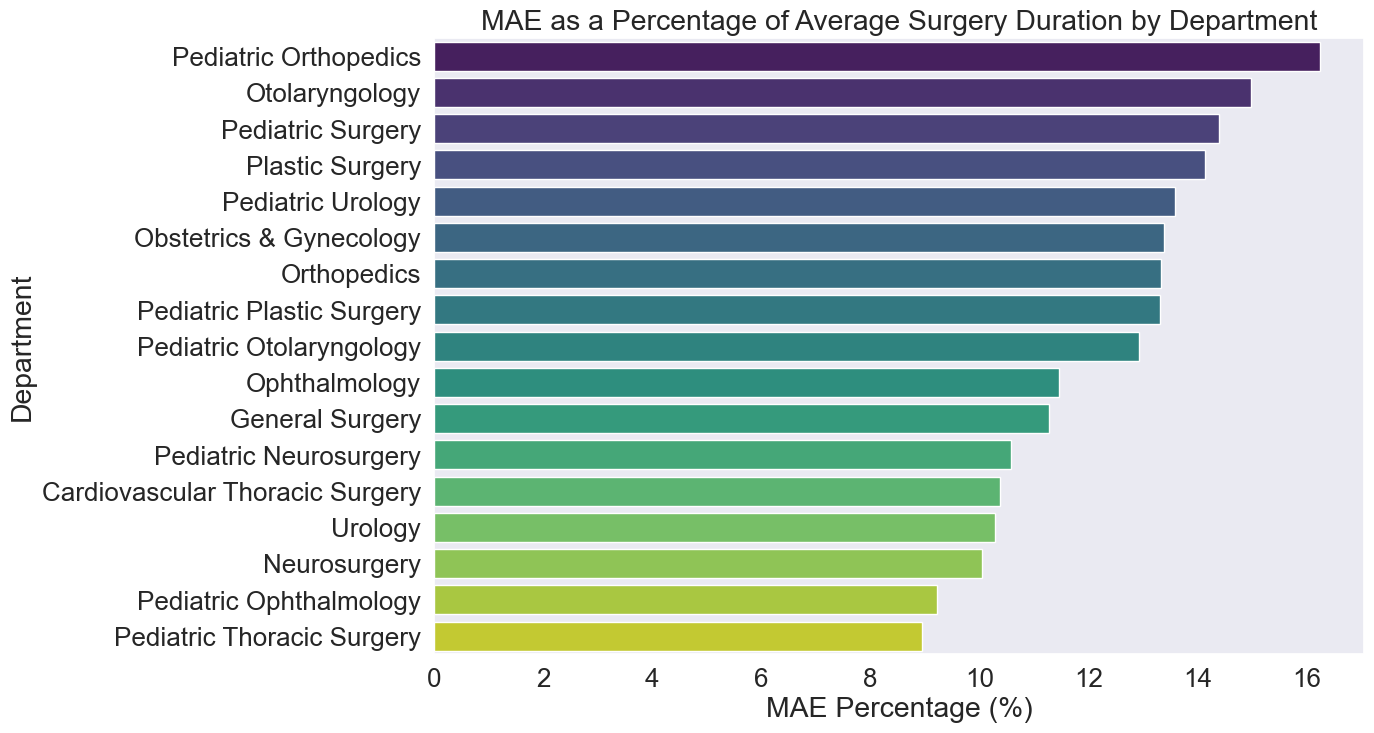

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculating the MAE as a percentage of the average surgery duration
dept_data_for_visualization['MAE Percentage'] = (dept_data_for_visualization['MAE'] / dept_data_for_visualization['Average Surgery Duration']) * 100

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x='MAE Percentage', y='Department', data=dept_data_for_visualization.sort_values('MAE Percentage', ascending=False), palette='viridis')
    
plt.title('MAE as a Percentage of Average Surgery Duration by Department')
plt.xlabel('MAE Percentage (%)')
plt.ylabel('Department')
plt.grid(axis='x')
plt.show()



In [27]:
# Displaying adult_data as a table
adult_data_table = adult_data[['Department', 'Average Surgery Duration', 'MAE', 'MAE Percentage']].sort_values(by='Average Surgery Duration', ascending=False)
adult_data_table

,Department,Average Surgery Duration,MAE,MAE Percentage
2,Neurosurgery,239.383053,24.036820,10.041154
0,Cardiovascular Thoracic Surgery,233.352425,24.201056,10.371033
1,General Surgery,155.665771,17.552547,11.275791
15,Plastic Surgery,139.252837,19.690603,14.140181
6,Otolaryngology,139.036018,20.814276,14.970420
5,Orthopedics,133.923572,17.857228,13.333895
3,Obstetrics & Gynecology,131.534839,17.595469,13.377041
16,Urology,115.427910,11.859826,10.274660
4,Ophthalmology,57.755921,6.612982,11.449877


In [28]:
# Displaying adult_data as a table
pediatric_data_table = pediatric_data[['Department', 'Average Surgery Duration', 'MAE', 'MAE Percentage']].sort_values(by='Average Surgery Duration', ascending=False)
pediatric_data_table

,Department,Average Surgery Duration,MAE,MAE Percentage
7,Pediatric Neurosurgery,296.249571,31.342446,10.579744
13,Pediatric Thoracic Surgery,269.852878,24.111563,8.935077
9,Pediatric Orthopedics,143.927017,23.369874,16.237308
11,Pediatric Plastic Surgery,115.201977,15.333567,13.310159
14,Pediatric Urology,114.517983,15.546562,13.575651
12,Pediatric Surgery,97.210395,13.992521,14.394058
10,Pediatric Otolaryngology,84.302394,10.895329,12.924103
8,Pediatric Ophthalmology,56.627339,5.215410,9.210057


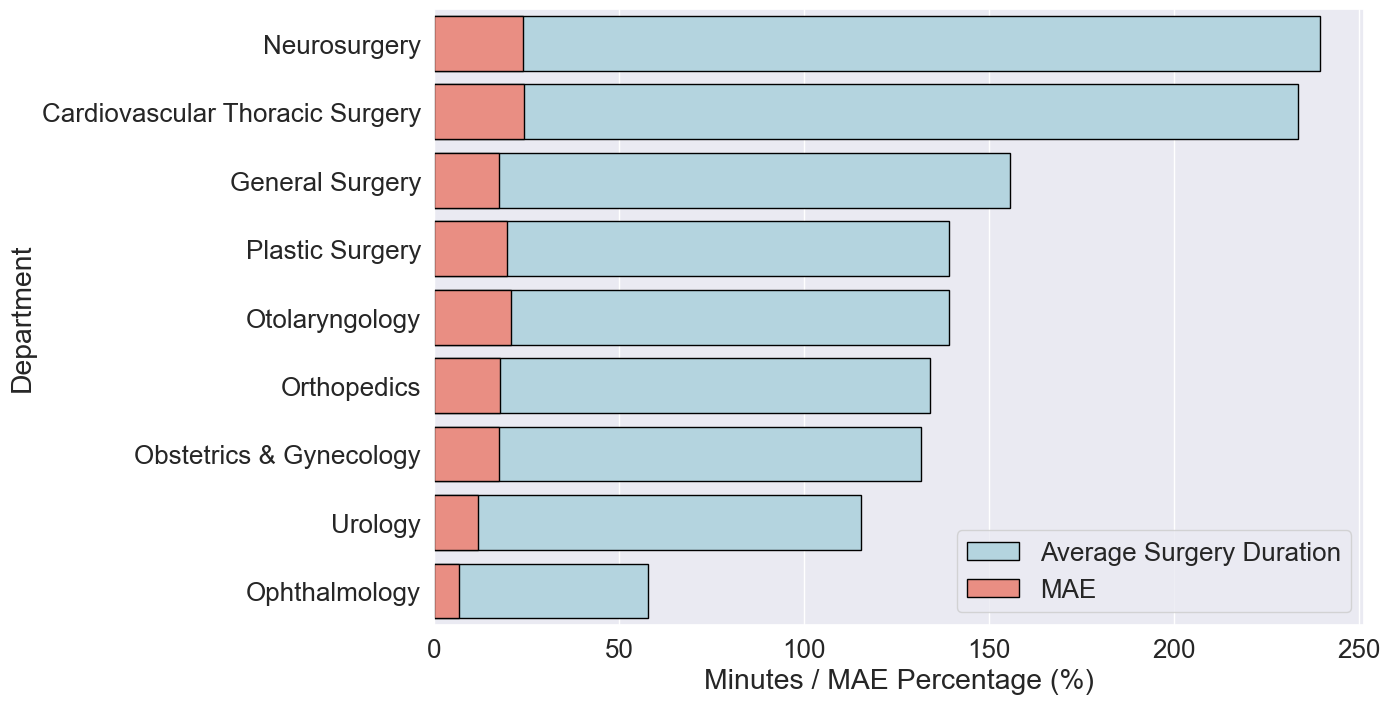

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set font scale
sns.set(font_scale=1.7)

# Combined plot for both Adult and Pediatric Departments, sorted by Average Surgery Duration
plt.figure(figsize=(12, 8))

# Plot for Adult Departments
sns.barplot(x='Average Surgery Duration', y='Department', data=adult_data_sorted, color='lightblue', edgecolor='black', label='Average Surgery Duration')
sns.barplot(x='MAE', y='Department', data=adult_data_sorted, color='salmon', edgecolor='black', label='MAE')
#plt.title('Adult Departments: Average Surgery Duration, MAE, and MAE Percentage')
plt.xlabel('Minutes / MAE Percentage (%)')
plt.ylabel('Department')
plt.legend()
plt.show()


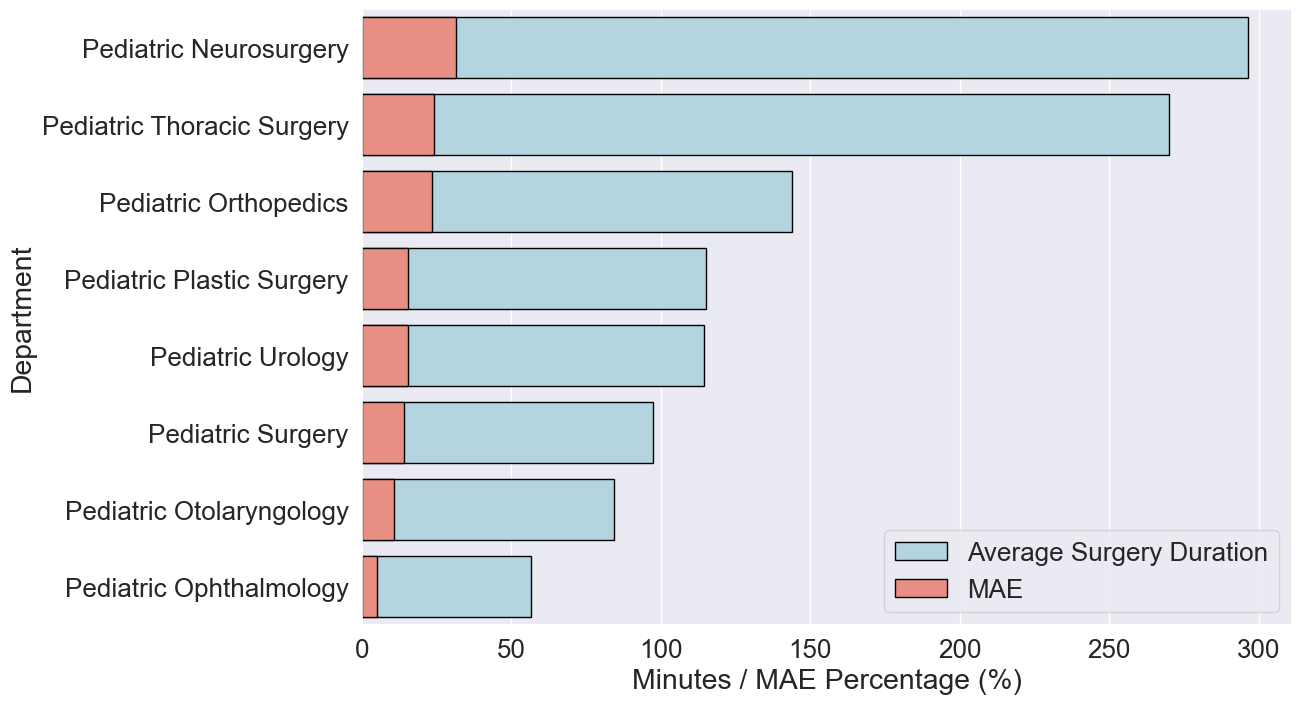

In [30]:
# Plot for Pediatric Departments
sns.set(font_scale=1.7)

plt.figure(figsize=(12, 8))
sns.barplot(x='Average Surgery Duration', y='Department', data=pediatric_data_sorted, color='lightblue', edgecolor='black', label='Average Surgery Duration')
sns.barplot(x='MAE', y='Department', data=pediatric_data_sorted, color='salmon', edgecolor='black', label='MAE')
#plt.title('Pediatric Departments: Average Surgery Duration, MAE, and MAE Percentage')
plt.xlabel('Minutes / MAE Percentage (%)')
plt.ylabel('Department')
plt.legend()
plt.show()